In [1]:
## Options
import pandas as pd
from PI_client import pi_client
pi = pi_client()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%load_ext autoreload
%autoreload 2

### Local Data Loading

In [2]:
# filePath = 'data/OATtest.xlsx'
filePath = 'data/gbsfkilledvif.xlsx'
data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True)
print(data.columns)

Index([u'chw', u'steam', u'ele', u'OAT'], dtype='object')


### PI Data Loading

In [3]:
tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

print(tags)

[u'Shields_ChilledWater_Demand_kBtu', u'Shields_Electricity_Demand_kBtu', u'Shields_Steam_Demand_kBtu']


#### Pull tags

In [4]:
startDate = '2017-01-01'
endDate = '2018-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

# data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

In [5]:
## Imports

## Mac imports
# import sys
# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

## Main Imports
import mnv13 as mnv
print(mnv.version)
import matplotlib.pyplot as plt
print("Success!")

Version 1.3
Success!


# Data Section

Q(75%): 357.91 Q(25%): 70.25
IQR value is 287.66
Ceiling adjusted by IQR - Now 1508.55


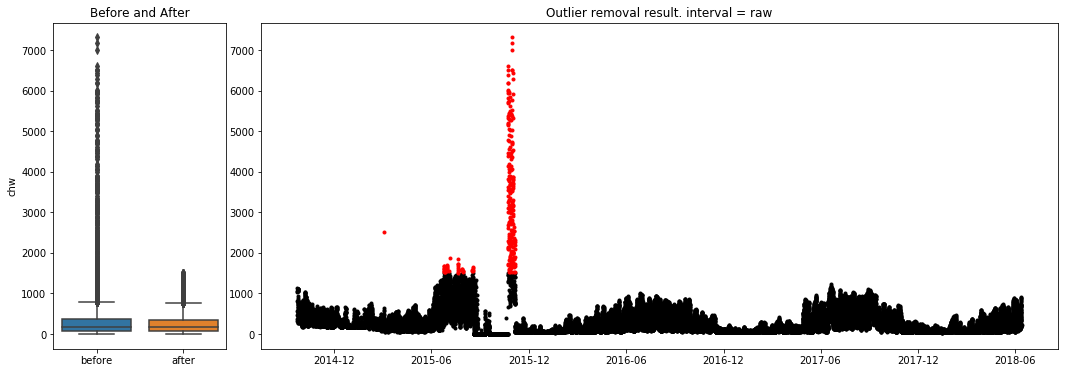

Deprecation warning: this function should be called calculate_degree_hours(). Use that name instead
OAT being loaded from master file


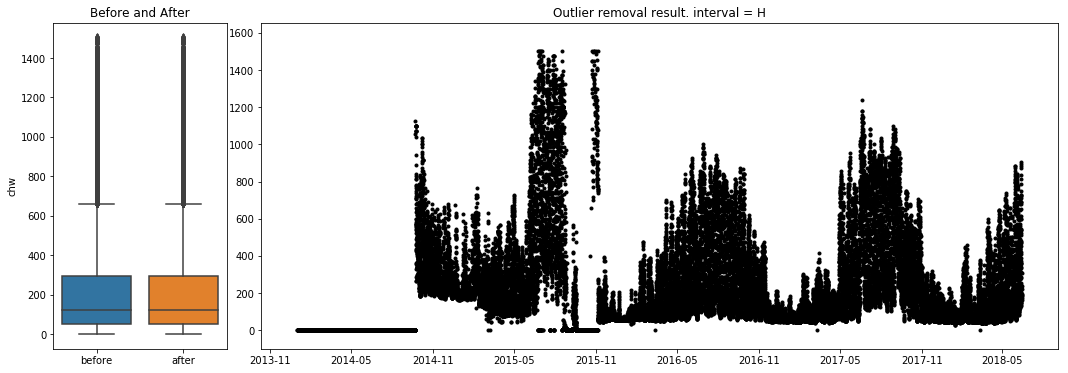

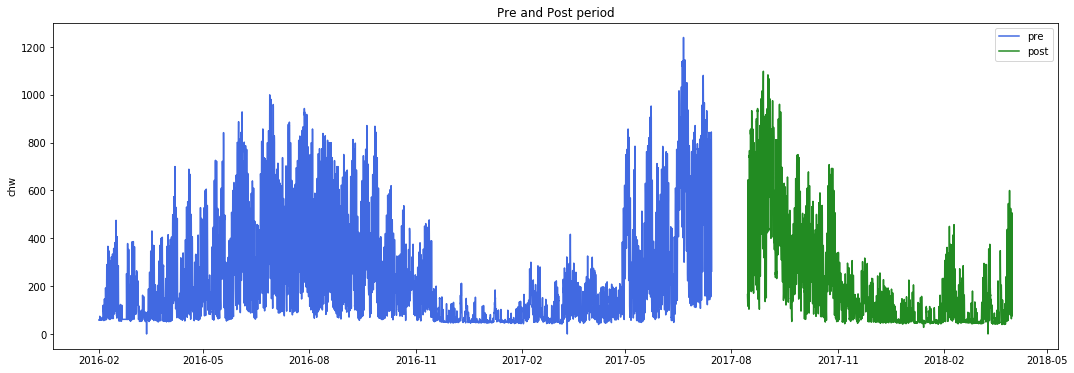

In [15]:
inputDict = {'IQRmult' : 4.0,
             'IQR' : 'y', 
             'resampleRate' : 'H', #'D' for daily 'H' for hourly
             'verbosity' : 3,
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2016-02-01','2017-07-15','2017-08-15','2018-04-01'], #only needed with sliceType : 'ranges'
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data[data.columns[0]], inputDict)
dc.default_clean()

## Run the next line incase the y-range is FUBAR
dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1)) 

# plot 3
dc._pre_post_plot()

# Many Linear Models

In [17]:
modelDict = {'params': 'CDH + HDH + C(month) + C(weekday)',
             'testTrainSplit': 'random',
             'randomState': None,
             'testSize': 0.2,
             'commodityRate': 0.056,
             'paramList': ['','C(weekday)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(0)
modelDict['params'] = allmod.statsPool.iloc[0]['params']

[]
Could not calculate VIF for CDH + HDH
Exception caught: exog contains inf or nans
['weekday']
Could not calculate VIF for CDH + HDH + C(weekday)
Exception caught: exog contains inf or nans
[]
Could not calculate VIF for CDH + HDH2
Exception caught: exog contains inf or nans
['weekday']
[]
Could not calculate VIF for CDH
Exception caught: exog contains inf or nans
['weekday']
Could not calculate VIF for CDH + C(weekday)
Exception caught: exog contains inf or nans
[]
Could not calculate VIF for CDH2 + HDH
Exception caught: exog contains inf or nans
['weekday']
Could not calculate VIF for CDH2 + HDH + C(weekday)
Exception caught: exog contains inf or nans
[]
Could not calculate VIF for CDH2 + HDH2
Exception caught: exog contains inf or nans
['weekday']
[]
Could not calculate VIF for CDH2
Exception caught: exog contains inf or nans
['weekday']
Could not calculate VIF for CDH2 + C(weekday)
Exception caught: exog contains inf or nans
[]
Could not calculate VIF for HDH
Exception caught: ex

# Single Linear Model

['weekday']
Could not calculate VIF for CDH + HDH + C(weekday)
Exception caught: exog contains inf or nans


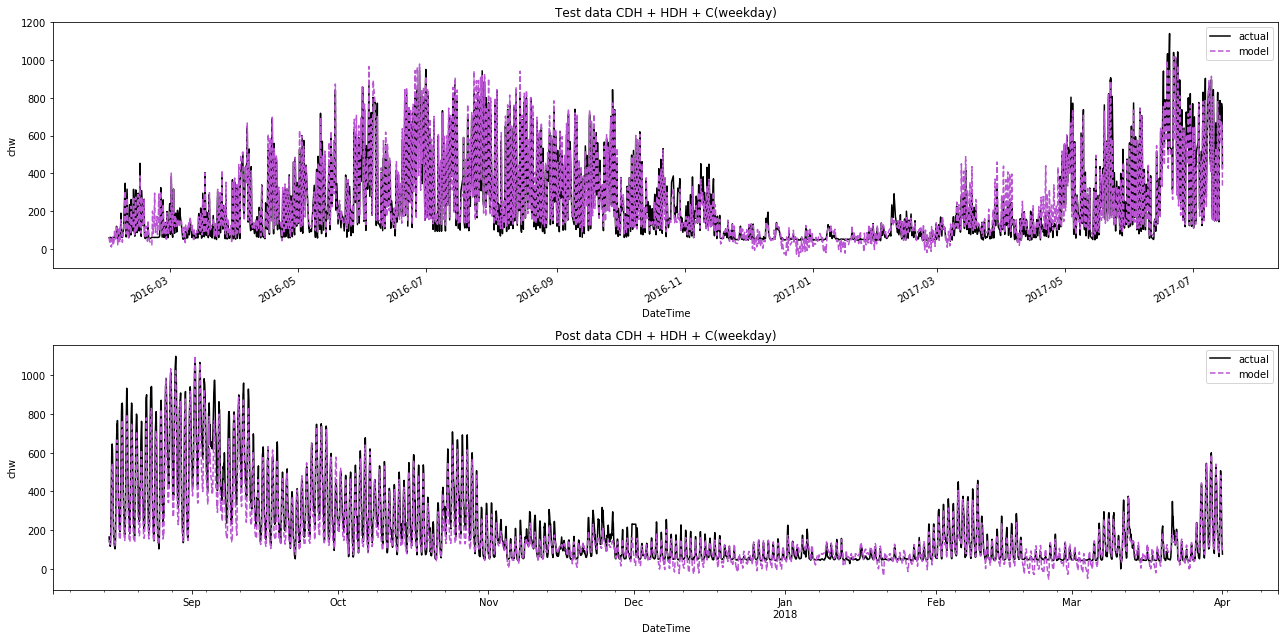

None


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chw   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 6.001e+04
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:20:15   Log-Likelihood:                -54392.
No. Observations:               10174   AIC:                         1.088e+05
Df Residuals:                   10170   BIC:                         1.088e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          160.1430      1.187    134.912      0.000     157.816     162.470
C(weekday)[T.1L]    13.6053      1.115     12.199      0.000      11.419      15.791
CDH                 22.5772      0.070    322.380      0.000      22.440      22.715
HDH                 -7.2458      0.087    -83.143      0.000      -7.417      -7.075
==============================================================================
Omnibus:                      968.869   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7279.820
Skew:                           0.056   Prob(JB):                         0.00
Kurtosis:                       7.142   Cond. No.                         28.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()


plt.show() # Show plot before Stats summary
print(mod.vif)
mod.Fit.summary()

In [14]:
mod.kfold()
print(mod.kfoldStats)
print('')
print(mod.kfoldRelative.round(1))

(0.2, 'nfolds', 5)
         R2       AR2           mse
2  0.547049  0.546972  31859.143053
4  0.546258  0.546182  32160.378027
3  0.540966  0.540889  32443.244710
1  0.541503  0.541425  32508.795404
0  0.543090  0.543013  32703.672397

2         98.5
4         99.5
3        100.3
1        100.5
0        101.1
mse    32335.0
dtype: float64


### Savings

Savings = $-3056.34


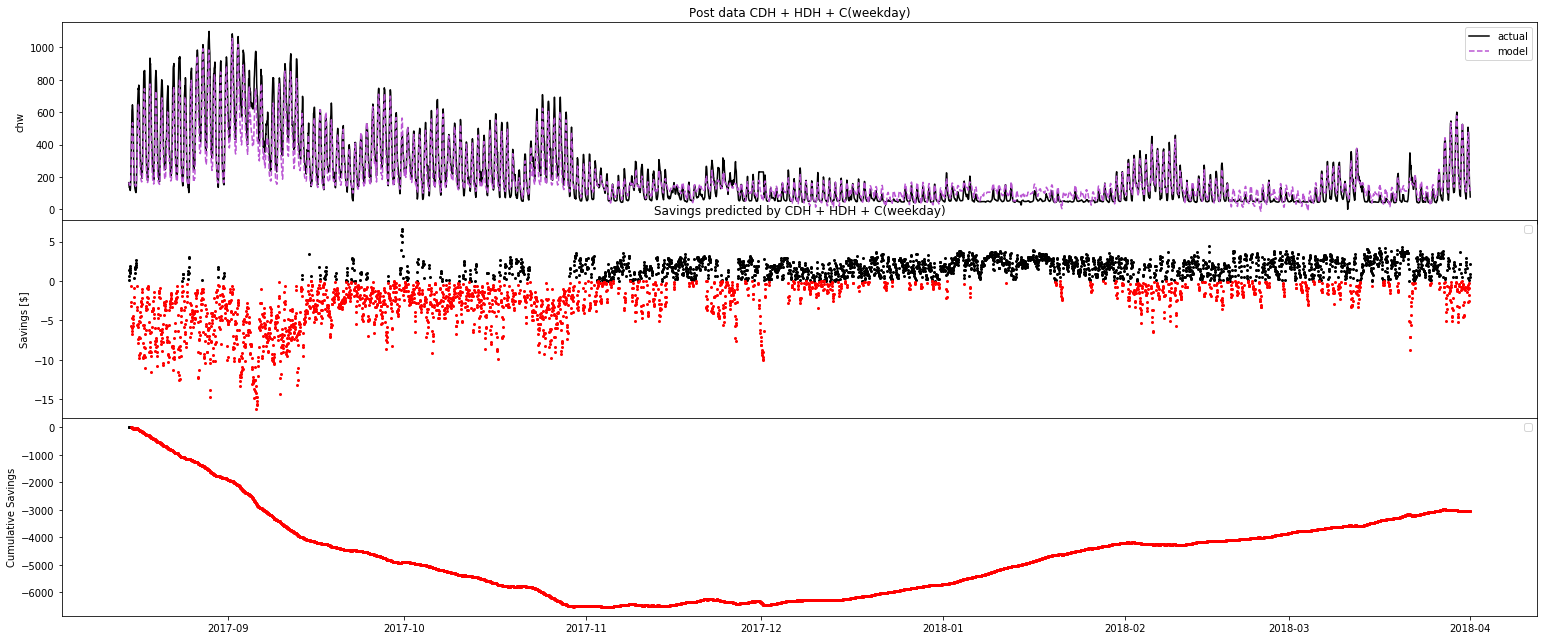

In [10]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'

print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,2)))
mod.savings_plot(yaxis='dollars')